In [14]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split

import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import shap
import category_encoders as ce
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.utils import shuffle
import seaborn as sns

from scipy.stats import randint

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, precision_score

import seaborn as sns
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [3]:
df = pd.read_parquet('final_data.parquet')

In [4]:
import pandas as pd
from sklearn.utils import shuffle

spam_emails = df[df['label'] == 1]
normal_emails = df[df['label'] == 0]

undersampled_normal_emails = normal_emails.sample(n=len(spam_emails), random_state=42)

balanced_df = pd.concat([spam_emails, undersampled_normal_emails])

balanced_df = shuffle(balanced_df, random_state=42)

from sklearn.model_selection import train_test_split

X = balanced_df.drop(columns=['label', 'SourceFile', 'Subject', 'Recipients', 'Sender', 'RawEmailBody', 'PlainTextEmailBody', 'processed_text', 'clean_text', 'sentiment'], axis=1)
y = balanced_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

In [7]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9578531445505433


In [8]:
param_dist = {
    'n_estimators': randint(50, 100), 
    'max_depth': randint(5, 10),  
    'class_weight': ['balanced', 'balanced_subsample', None]  
}

rf = RandomForestClassifier()

rand_search = RandomizedSearchCV(rf, 
                                 param_distributions=param_dist, 
                                 n_iter=30,  
                                 cv=5, 
                                 n_jobs=-1,
                                 scoring=make_scorer(precision_score, zero_division=0, average='binary'))  

rand_search.fit(X_train, y_train)

print("Best parameters for high precision:", rand_search.best_params_)

Best parameters for high precision: {'class_weight': 'balanced', 'max_depth': 9, 'n_estimators': 89}


In [11]:
best_rf=rand_search.best_estimator_
y_pred = best_rf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Precision:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9459993414553836
Recall: 0.990914990266061
Precision: 0.990914990266061


In [12]:
y_pred_prob = best_rf.predict_proba(X_test)[:, 1]

In [15]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

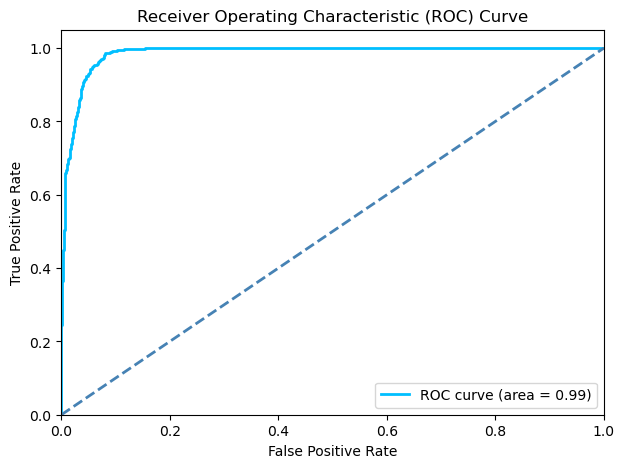

In [28]:
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='deepskyblue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='steelblue', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.rcParams['font.family'] = 'sans'  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()